# ETR: Enhancing Transformation Reduction for Reducing Dimensionality and Classification Complexity in Hyperspectral Images 

In [1]:
import keras
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
from operator import truediv
from plotly.offline import init_notebook_mode

from numpy.core.fromnumeric import shape
from skimage.morphology import reconstruction
from sklearn.preprocessing import QuantileTransformer


import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os
import pandas as pd
import time
import seaborn as sn

init_notebook_mode(connected=True)
%matplotlib inline

In [2]:
def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test

# ETR methods

In [3]:
import pandas as pd
import numpy as np

def extract_pixels(X, y):
  #q = X.reshape(-1, X.shape[2])
  df = pd.DataFrame(data = X)
  df = pd.concat([df, pd.DataFrame(data = y.ravel())], axis=1)
  df.columns= [f'band{i}' for i in range(1, 1+X.shape[1])]+['class']

  return df

In [4]:
def first_step(X, orgin, numComponents):

  # Calculate the covariance matrix first
  
  correlation_matrix = np.corrcoef(orgin.T)
 
  covariance_matrix = np.cov(X.T)   # The result is a Positive semidefinite matrix
  
  final_matrix = covariance_matrix - correlation_matrix
  
  # Eigendecomposition of the covariance
  eigen_values, eigen_vectors = np.linalg.eig(final_matrix)
  # Calculate the variance explained on each of those components
  variance_explained = [(i/sum(eigen_values))*100 for i in eigen_values]
  # Calculate the cumulative sum of variance explained
  cumulative_variance_explained = np.cumsum(variance_explained)
  #Taking two components and create a projection matrix
  projection_matrix = (eigen_vectors.T[:][:numComponents]).T
  
  # Calculate the product of X (standardized original data multiply by eigenvectors)

  X_w = X.dot(projection_matrix)

  return X_w

In [5]:
def ETR(X1, y1, status = 'max', min_no = 1, numComponents=15):
  scaler=[]
  y = []
  try:

    df = extract_pixels(X1, y1)
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1]
    
    X = first_step(X,X.iloc[:, :], numComponents)

    # the second step of the ETR method
    X_mean = X
    if status == 'max':
      X_mean['mean'] = X_mean.max(axis=1)* min_no

    elif status == 'mean':
      X_mean['mean'] = X_mean.mean(axis=1)

    else:
      print("You should choose the max or mean status, and if max add the sigma value")
      return None

    Avr = [X_mean['mean']]
    rep_Avr = np.repeat(Avr, numComponents)
    rep_Avr =np.reshape(rep_Avr, (-1,numComponents))
    main_X = X.iloc[:, :-1]
    seed = main_X - rep_Avr
    
    dilated = reconstruction(seed.values, main_X.values)    
    #print(dilated)
    scaler = QuantileTransformer(n_quantiles=15, random_state=0,output_distribution='normal') #
    scaler = scaler.fit_transform(dilated)
   
  except:
    print("Please use max status with sigma value rather than the min status")
  
  return scaler, y 

# Data Loading

In [6]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Importing the dataset
dataset = pd.read_csv('aa.csv')
X = dataset.iloc[:, 1:15].values
y11 = dataset.iloc[:, 15].values

In [7]:
dataset = 'aa'
numComponents = 4
test_ratio = 0.2
#windowSize = 15
h1 = X.shape[0]
w1 = X.shape[1]
X.shape, y11.shape

((158, 14), (158,))

In [8]:
status = 'max' #'mean' or 'max' choosing the status is used to enhance classes' variation.
sigma = 0.30 # σ is used to reduce the distance between values of the same class.

X1, y1 = ETR(X,y11, status, sigma, numComponents)


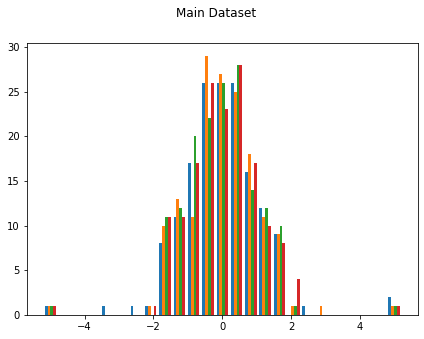

In [9]:
from matplotlib import pyplot
pyplot.figure(figsize=(7,5))
pyplot.hist(X1[:,:], bins=25)
pyplot.suptitle("Main Dataset")
pyplot.show()


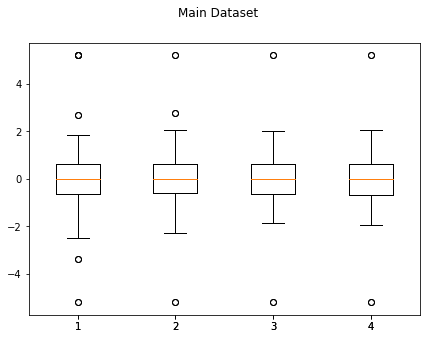

array([-5.19933758, -3.36521745,  5.19933758,  5.19933758,  2.67070568])

In [10]:
pyplot.figure(figsize=(7,5))
c = pyplot.boxplot(X1[:,:])
top_points = c["fliers"][0].get_data()[1]
pyplot.boxplot(X1[:,:])
pyplot.suptitle("Main Dataset")
pyplot.show()
top_points